## Introduction
In this assessment we want to use the tools of data science and analysis to estimate the probability that the outcome of each pitch will be a swing and a miss. The final deliverable will be a column with the predicted probability of a swing and a miss on that pitch. This will help us in identifying pitching talent in years to come, even if they have not pitched in the MLB.

Additionally, we want to identify the top 3 pitcher-pitch type combinations that are most likely to produce a swing and a miss. 

We will also establish what inputs in our model drive our predcitions to the greatest extent. 

In [2]:
# Importing necessary libraries

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import missingno as msno

# Machine Learning Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.pipeline import Pipeline

## Importing our data

In [43]:
train = pd.read_csv('/Users/williamearley/ProblemSet_2022/Application_Train_01.csv', dtype=dtype_dict)
holdout = pd.read_csv('/Users/williamearley/ProblemSet_2022/Application_Holdout_01.csv')

/var/folders/25/ys3kvvh94qz9hdnmxh9q884h0000gn/T/ipykernel_75347/1427493882.py:1: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('/Users/williamearley/Documents/Professional/Jobs/Sports/Red Sox/ProblemSet_2022/Application_Train_01.csv', dtype=dtype_dict)


## Exploring Data

In [4]:
# Let's take a look at the first 5 rows

train.head(5)

,GameDate,Season,GameNumber,GameSeqNum,DayNight,Venue,Inning,TopInning,PAOfInning,PitchOfPA,...,ReleaseSpeed,PitchBreakVert,PitchBreakHorz,SpinRate,PlateLocX,PlateLocZ,PitchType,PitchResult,SwingFL,VideoLink
0,2018-03-29,2018,529406,1,Day,Tropicana Field,1,TOP,1,1,...,93.149803,9.25649,-2.79725,2080.520020,-0.349381,2.68717,FB,Ball in play,1,https://coach-video.mlb.com/mlb/2018/03/29/080...
1,2018-03-29,2018,529406,2,Day,Tropicana Field,1,TOP,2,1,...,93.987000,10.08530,-2.38452,2194.520020,-0.719828,2.27843,FB,Called strike,0,https://coach-video.mlb.com/mlb/2018/03/29/080...
2,2018-03-29,2018,529406,3,Day,Tropicana Field,1,TOP,2,2,...,94.888802,9.56553,-4.32191,2247.550049,-0.812270,3.11228,FB,Foul ball,1,https://coach-video.mlb.com/mlb/2018/03/29/080...
3,2018-03-29,2018,529406,4,Day,Tropicana Field,1,TOP,2,3,...,88.020103,7.93979,-6.94939,1867.280029,-0.776230,2.72569,CH,Ball in play,1,https://coach-video.mlb.com/mlb/2018/03/29/080...
4,2018-03-29,2018,529406,5,Day,Tropicana Field,1,TOP,3,1,...,94.235703,10.41860,-3.33595,2289.439941,0.056916,2.90783,FB,Foul ball,1,https://coach-video.mlb.com/mlb/2018/03/29/080...


In [6]:
# Looks like we have the expected 1288073 rows and 42 columns.

train.shape

(1288073, 42)

In [7]:
# Helpful to check out data types, and get a look at the complete list of columns. 

train.dtypes

GameDate             object
Season                int64
GameNumber            int64
GameSeqNum            int64
DayNight             object
Venue                object
Inning                int64
TopInning            object
PAOfInning            int64
PitchOfPA             int64
Balls                 int64
Strikes               int64
Outs                  int64
B1                    int64
B2                    int64
B3                    int64
HomeTeam             object
HomeScore             int64
AwayTeam             object
AwayScore             int64
PitcherID             int64
PitcherName          object
PitcherHand          object
BatterID              int64
BatterName           object
BatterHand           object
ReleaseLocX         float64
ReleaseLocY         float64
ReleaseLocZ         float64
ReleaseVelocityX    float64
ReleaseVelocityY    float64
ReleaseVelocityZ    float64
ReleaseSpeed        float64
PitchBreakVert      float64
PitchBreakHorz      float64
SpinRate            

In [8]:
# This describe command allows us to see some summary statistics of the numerical categories

train.describe()

,Season,GameNumber,GameSeqNum,Inning,PAOfInning,PitchOfPA,Balls,Strikes,Outs,B1,...,ReleaseVelocityX,ReleaseVelocityY,ReleaseVelocityZ,ReleaseSpeed,PitchBreakVert,PitchBreakHorz,SpinRate,PlateLocX,PlateLocZ,SwingFL
count,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,...,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06,1.288073e+06
mean,2.018496e+03,5.482671e+05,1.632323e+02,5.017542e+00,2.853730e+00,2.914915e+00,8.870708e-01,8.932273e-01,9.805213e-01,3.037126e-01,...,2.368163e+00,-1.299096e+02,-3.518354e+00,8.885940e+01,4.087331e+00,-1.151621e+00,2.232970e+03,7.827832e-03,2.290063e+00,4.656040e-01
std,4.999836e-01,1.780332e+04,9.925991e+01,2.676151e+00,1.648804e+00,1.740470e+00,9.694033e-01,8.262593e-01,8.169636e-01,4.598602e-01,...,6.357017e+00,8.566270e+00,3.270396e+00,5.861746e+00,5.129811e+00,5.982113e+00,3.163115e+02,8.594717e-01,9.543196e-01,4.988157e-01
min,2.018000e+03,5.294060e+05,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-2.087220e+01,-1.535570e+02,-1.947550e+01,5.506300e+01,-2.061910e+01,-1.904930e+01,3.759140e+02,-6.828730e+00,-4.504340e+00,0.000000e+00
25%,2.018000e+03,5.306000e+05,7.900000e+01,3.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-2.893870e+00,-1.365780e+02,-5.741260e+00,8.473160e+01,1.261670e+00,-6.263590e+00,2.084430e+03,-5.802850e-01,1.676820e+00,0.000000e+00
50%,2.018000e+03,5.318180e+05,1.580000e+02,5.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,...,4.290910e+00,-1.317970e+02,-3.732490e+00,9.014650e+01,5.156420e+00,-1.886190e+00,2.250650e+03,1.065320e-02,2.296160e+00,0.000000e+00
75%,2.019000e+03,5.661590e+05,2.410000e+02,7.000000e+00,4.000000e+00,4.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,...,7.072450e+00,-1.238710e+02,-1.522170e+00,9.342950e+01,8.180300e+00,3.624210e+00,2.415980e+03,5.967470e-01,2.912130e+00,1.000000e+00
max,2.019000e+03,5.703350e+05,6.020000e+02,1.800000e+01,1.500000e+01,2.100000e+01,4.000000e+00,2.000000e+00,2.000000e+00,1.000000e+00,...,2.078800e+01,-8.053490e+01,1.527400e+01,1.050690e+02,2.058790e+01,1.696600e+01,3.704960e+03,7.258210e+00,8.885490e+00,1.000000e+00


In [10]:
# We see the only category we have null values for is the video link, which is a good sign
train.isnull().sum()

GameDate                 0
Season                   0
GameNumber               0
GameSeqNum               0
DayNight                 0
Venue                    0
Inning                   0
TopInning                0
PAOfInning               0
PitchOfPA                0
Balls                    0
Strikes                  0
Outs                     0
B1                       0
B2                       0
B3                       0
HomeTeam                 0
HomeScore                0
AwayTeam                 0
AwayScore                0
PitcherID                0
PitcherName              0
PitcherHand              0
BatterID                 0
BatterName               0
BatterHand               0
ReleaseLocX              0
ReleaseLocY              0
ReleaseLocZ              0
ReleaseVelocityX         0
ReleaseVelocityY         0
ReleaseVelocityZ         0
ReleaseSpeed             0
PitchBreakVert           0
PitchBreakHorz           0
SpinRate                 0
PlateLocX                0
P

Even though we will be focusing on the training set for a bit, it's helpful to get a look at the holdout set as well.

In [23]:
holdout.tail(5)

,GameDate,Season,GameNumber,GameSeqNum,DayNight,Inning,TopInning,PAOfInning,PitchOfPA,Balls,...,ReleaseVelocityX,ReleaseVelocityY,ReleaseVelocityZ,ReleaseSpeed,PitchBreakVert,PitchBreakHorz,SpinRate,PlateLocX,PlateLocZ,PitchType
71060,2019-09-29,2019,567343,180,Day,6,BOTTOM,3,1,0,...,5.17128,-135.423004,-3.381640,92.792198,4.429590,-0.342061,2424.040039,0.043964,2.61216,FB
71061,2019-09-29,2019,567343,181,Day,6,BOTTOM,3,2,0,...,3.39307,-136.574005,-1.707110,93.507599,6.278580,-1.726360,2286.189941,-0.582575,3.61616,FB
71062,2019-09-29,2019,567343,182,Day,6,BOTTOM,3,3,1,...,3.20676,-124.529999,0.202386,85.334297,-0.363125,1.428260,2343.780029,-0.307507,2.82961,SL
71063,2019-09-29,2019,567343,183,Day,6,BOTTOM,3,4,1,...,4.89953,-138.149994,-2.180910,94.617401,4.541610,-0.666026,2468.669922,0.090355,3.31026,FB
71064,2019-09-29,2019,567343,184,Day,6,BOTTOM,4,1,0,...,2.52456,-118.365997,2.970700,81.067299,-7.778060,4.767060,2675.239990,-0.006986,2.67170,CB


In [13]:
# Notable we see the holdout section has 6 less columns and way fewer rows than the train set. 
# It does not have SwingFL, PitchResult, VideoLink, Venue, HomeTeam, AwayTeam, 
# PitcherName (has column but only with ID, no names), BatterID, BatterName

holdout.shape

(71065, 34)

In [12]:
holdout.dtypes

GameDate             object
Season                int64
GameNumber            int64
GameSeqNum            int64
DayNight             object
Inning                int64
TopInning            object
PAOfInning            int64
PitchOfPA             int64
Balls                 int64
Strikes               int64
Outs                  int64
B1                    int64
B2                    int64
B3                    int64
HomeScore             int64
AwayScore             int64
PitcherID             int64
PitcherName          object
PitcherHand          object
BatterHand           object
ReleaseLocX         float64
ReleaseLocY         float64
ReleaseLocZ         float64
ReleaseVelocityX    float64
ReleaseVelocityY    float64
ReleaseVelocityZ    float64
ReleaseSpeed        float64
PitchBreakVert      float64
PitchBreakHorz      float64
SpinRate            float64
PlateLocX           float64
PlateLocZ           float64
PitchType            object
dtype: object

In [20]:
holdout.describe()

,Season,GameNumber,GameSeqNum,Inning,PAOfInning,PitchOfPA,Balls,Strikes,Outs,B1,...,ReleaseLocZ,ReleaseVelocityX,ReleaseVelocityY,ReleaseVelocityZ,ReleaseSpeed,PitchBreakVert,PitchBreakHorz,SpinRate,PlateLocX,PlateLocZ
count,71065.0,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,...,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000,71065.000000
mean,2019.0,566185.452093,161.474523,4.858454,2.860494,2.926687,0.900218,0.897657,0.985028,0.298698,...,5.871175,2.451304,-129.648279,-3.210154,88.753022,3.509862,-0.880553,2211.449604,0.016266,2.263151
std,0.0,844.578813,100.529068,2.667097,1.653719,1.728839,0.973745,0.825432,0.820537,0.457691,...,0.583474,6.028120,8.821435,3.457930,6.041904,5.521935,5.726548,320.723405,0.853623,0.966065
min,2019.0,564736.000000,4.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.114826,-17.562099,-149.947006,-16.239599,58.074799,-14.789400,-15.095900,433.959991,-4.906890,-2.832530
25%,2019.0,565461.000000,77.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,5.615860,-2.343510,-136.585999,-5.643750,84.600700,0.200039,-5.637260,2054.570068,-0.568845,1.634490
50%,2019.0,566235.000000,152.000000,5.000000,3.000000,3.000000,1.000000,1.000000,1.000000,0.000000,...,5.937450,4.183740,-131.223999,-3.540030,89.820702,4.722660,-1.189810,2236.699951,0.024687,2.263380
75%,2019.0,566935.000000,237.000000,7.000000,4.000000,4.000000,2.000000,2.000000,2.000000,1.000000,...,6.245440,6.905760,-123.579002,-1.107250,93.487198,8.080170,3.690900,2402.879883,0.605401,2.891860
max,2019.0,567628.000000,624.000000,18.000000,13.000000,14.000000,3.000000,2.000000,2.000000,1.000000,...,7.035070,17.182301,-84.655502,17.333799,102.441002,14.099900,14.711000,3702.520020,4.384330,9.691630


In [19]:
# no nulls in the holdout set

holdout.isnull().sum()

GameDate            0
Season              0
GameNumber          0
GameSeqNum          0
DayNight            0
Inning              0
TopInning           0
PAOfInning          0
PitchOfPA           0
Balls               0
Strikes             0
Outs                0
B1                  0
B2                  0
B3                  0
HomeScore           0
AwayScore           0
PitcherID           0
PitcherName         0
PitcherHand         0
BatterHand          0
ReleaseLocX         0
ReleaseLocY         0
ReleaseLocZ         0
ReleaseVelocityX    0
ReleaseVelocityY    0
ReleaseVelocityZ    0
ReleaseSpeed        0
PitchBreakVert      0
PitchBreakHorz      0
SpinRate            0
PlateLocX           0
PlateLocZ           0
PitchType           0
dtype: int64

## Feature Engineering

We have a good setup for machine learning here. We have mostly numeric features, many of which match in both the train and holdout sets. What we need to do is a bit of feature engineering to get the dataframes in a good place to be able to work with machine learning models.

To begin, let's start with the first task. We have a classic regression task here, we will use previous information, to predict the probability that a batter will swing and miss. 

First we are going to drop a few columns. Given a bit more time, something I would like to investigate is temporal modeling. I would be interested to see how pitchers perform throughout the season, on different days of the week, and in different seasons. It would be my guess that games on more popular nights for fans (thursday - Sunday) would draw better performances from the fans. Also, I would expect that pitchers have better performances toward the end of the season as their team may be fighting for playoff positioning, or perhaps, they would have poorer performances as their team is already out of the hunt. I have done a lot of time series analysis and would pursue models like SARIMAX, FBProphet, and XGBoost (and will likely do a dive into this even after my submission). But for now, I am going to focus on the other features and disregard the GameDate. 

I will also be dropping venue as it is not in the holdout set. But again, will likely do a deep dive to see whether pitchers perform better in certain ball parks. There are many factors that could influence this like weather, dome vs. outside, fans, etc.

Team, player names and video link will be dropped as well.

In [62]:
train.columns

Index(['GameDate', 'Season', 'GameNumber', 'GameSeqNum', 'DayNight', 'Venue',
       'Inning', 'TopInning', 'PAOfInning', 'PitchOfPA', 'Balls', 'Strikes',
       'Outs', 'B1', 'B2', 'B3', 'HomeTeam', 'HomeScore', 'AwayTeam',
       'AwayScore', 'PitcherID', 'PitcherName', 'PitcherHand', 'BatterID',
       'BatterName', 'BatterHand', 'ReleaseLocX', 'ReleaseLocY', 'ReleaseLocZ',
       'ReleaseVelocityX', 'ReleaseVelocityY', 'ReleaseVelocityZ',
       'ReleaseSpeed', 'PitchBreakVert', 'PitchBreakHorz', 'SpinRate',
       'PlateLocX', 'PlateLocZ', 'PitchType', 'PitchResult', 'SwingFL',
       'VideoLink'],
      dtype='object')

In [63]:
# Dropping necessary columns from train

to_drop = ['GameDate', 'Venue', 'HomeTeam', 'AwayTeam', 'PitcherName', 'BatterName', 'BatterID', 'SwingFL', 'VideoLink']

train_eng = train.drop(columns=to_drop)

In [45]:
# Dropping necessary columns from holdout

to_drop_holdout = ['GameDate', 'PitcherName']

holdout_eng = holdout.drop(columns=to_drop_holdout)

### Label encoding
When we encode features, it allows us to more easily utilize them in our machine learning models. Here we will encode the object datatypes.

In [64]:
# We need to encode the object categories for modeling
# We start by doing this for the engineered train dataframe

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode each necessary column
for column in ['DayNight', 'TopInning', 'PitcherHand', 'BatterHand', 'PitchType', 'PitchResult']:
    train_eng[column] = label_encoder.fit_transform(train_eng[column])

In [65]:
# Encode each necessary column
for column in ['DayNight', 'TopInning', 'PitcherHand', 'BatterHand', 'PitchType']:
    holdout_eng[column] = label_encoder.fit_transform(holdout_eng[column])

Almost done with feature engineering, we just need to create a column that represents whether or not there was a swing and a miss, which will eventually be our target variable. 

In [66]:
# If the PitchResult is a "Swinging Strike" which corresponds with 6 for the label endocing, we want to put a 1
# in SwingMiss, if not, we put a zero.

train_eng['SwingMiss'] = np.where(train_eng['PitchResult'] == 6, 1, 0)

In [85]:
# Now we can drop "PitchResult" since it is not in the holdout set and we have the info we need

train_eng = train_eng.drop(columns='PitchResult')

# Modeling
This is an interesting problem as we want to assign a probability based on a binary classification task. One of my favorite machine learning algorithms, XGBoost (eXtreme Gradient Boosting) fits well here. XGBoost uses gradient boosting framework and performs well in scenarios like we have here. Its efficiency and scalability will suit well for predicting the probability of a swing and a miss.

In [86]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Separate features (X) and target variable (y)
X = train_eng.drop(columns=['SwingMiss'])  # these are the features we will feed into our model
y = train_eng['SwingMiss']  # This is our guide, our target variable about what we would like to predict.

# Split the data into training and holdout set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
probabilities = xgb_model.predict_proba(X_test)[:, 1]  # Probability of swing and miss.

In [87]:
# Add predicted probabilities to the test set
X_test['Probability_SwingMiss'] = probabilities

In [88]:
# Here we want to assess the accuracy of our model using mean squared error.

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, probabilities)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.08800165507015004


The incredibly low MSE shows that our model is very accurate. This is a great sign and we will continue to move forward. If I had a bit more time I would try some other models and compare their MSE. Logistic Regression, Random Forests, Support Vector Machines, and even Neural Networks could be good candidates here. I also would implement hyperparameter tuning with my XGBoost mode to achieve the highest accuracy possible. 

In [93]:
# Need to drop the SwingMiss column for predictions

train_eng = train_eng.drop(columns='SwingMiss')

In [94]:
# We will not use the model to predict on the entire training set

# Make predictions on the training set
probabilities_train = xgb_model.predict_proba(train_eng)[:, 1]  # Probability of swing and miss.

In [95]:
# Add predicted probabilities to the train set
train['Probability_SwingMiss'] = probabilities_train

In [89]:
# We will not use the model to predict on the holdout set

# Make predictions on the holdout set
probabilities_holdout = xgb_model.predict_proba(holdout_eng)[:, 1]  # Probability of swing and miss.

In [90]:
# Add predicted probabilities to the holdout set
holdout['Probability_SwingMiss'] = probabilities_holdout

# Problem 2
We now have our predicted swing and miss probabilities to let's take a look at the second problem. We want to, based on the predictions in the holdout set obtained from 1), identify the top 3 pitcher-pitch  type combinations that are likeliest to produce a swing and miss when thrown by the pitcher in  the future. In addition, what inputs to your model(s) seem to be driving that prediction for that  particular pitch the most?

In order to achieve this task, we will:

    1. Group the holdout set by pitcher ID and pitch type.
    2. Find the average predicted probability of a swing and miss for these combinations.
    3. Sort the combinations based on average predicted probability of swing and miss.
    4. Identify the three highest averages!

In [110]:
# Grouping by PitcherID and PitchType while finding the mean of probabilities
avg_probabilities = holdout.groupby(['PitcherID', 'PitchType'])['Probability_SwingMiss'].mean().reset_index()

In [111]:
# Sorting the results by average swing and miss probablities from highest to lowest
top_combos = avg_probabilities.sort_values(by='Probability_SwingMiss', ascending=False)

In [113]:
# Merge top_combos with train on PitcherID
top_combos_with_names = pd.merge(top_combos, train[['PitcherID', 'PitcherName']], on='PitcherID', how='left')

In [123]:
top_combos_with_names.head(3)

,PitcherID,PitchType,Probability_SwingMiss,PitcherName
0,364506,CH,0.285277,NaN
1,351636,SL,0.273503,NaN
2,329342,FB,0.256355,NaN


Since Pitcher isn't in the holdout set, we don't know the actual names of the pitchers that are most prolific at causing the outcome of a swing and miss, we do however know their PitcherID. I checked to see if any of these were present in the train set but as stated in the directions they are not.

We do know however that the top three Pitcher-Pitch combinations were 364506-Change Up 351636-Slider and 329342-Fastball. 

We will now use a technique called SHAP (Shapley Additive exPlanations) to determine what is impacting these results. SHAP will produce values that explain the output of our XGBoost model.

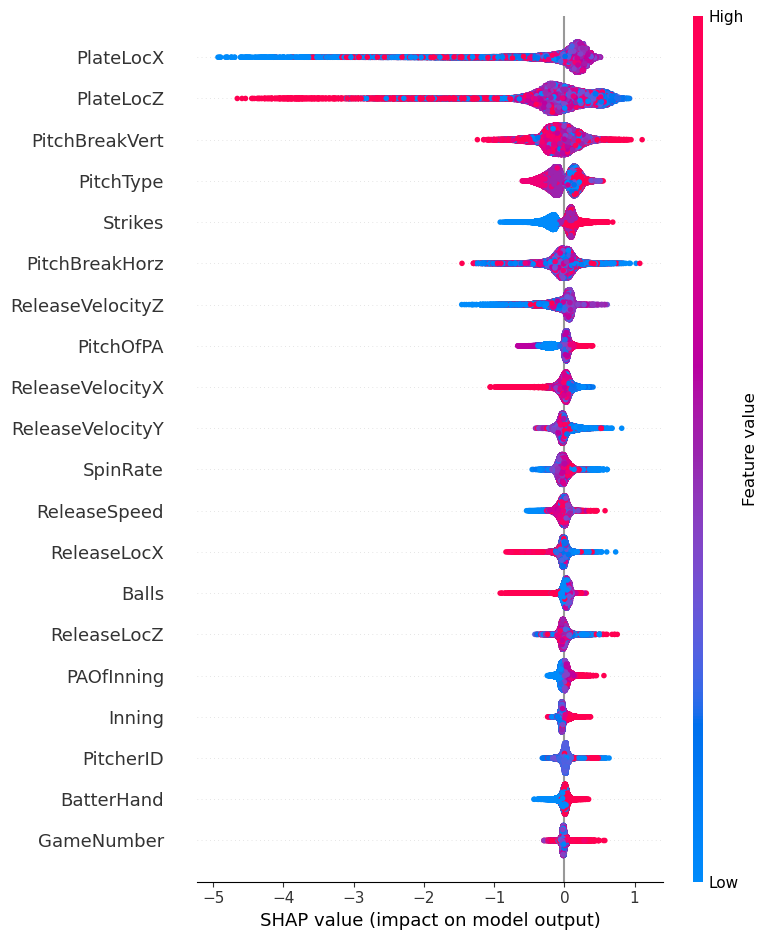

In [125]:
import shap

# Creating an explainer object
explainer = shap.Explainer(xgb_model)

# Calculating SHAP values for our test instances
shap_values = explainer.shap_values(holdout_eng)

# Visualize SHAP values in a summary plot
shap.summary_plot(shap_values, holdout_eng)

Above is the SHAP value plot for all the features, which is really cool to see the ways different features influence the predictions. Now let's see just for our top 3 pitcher-pitch combinations, what features just make these work so well.

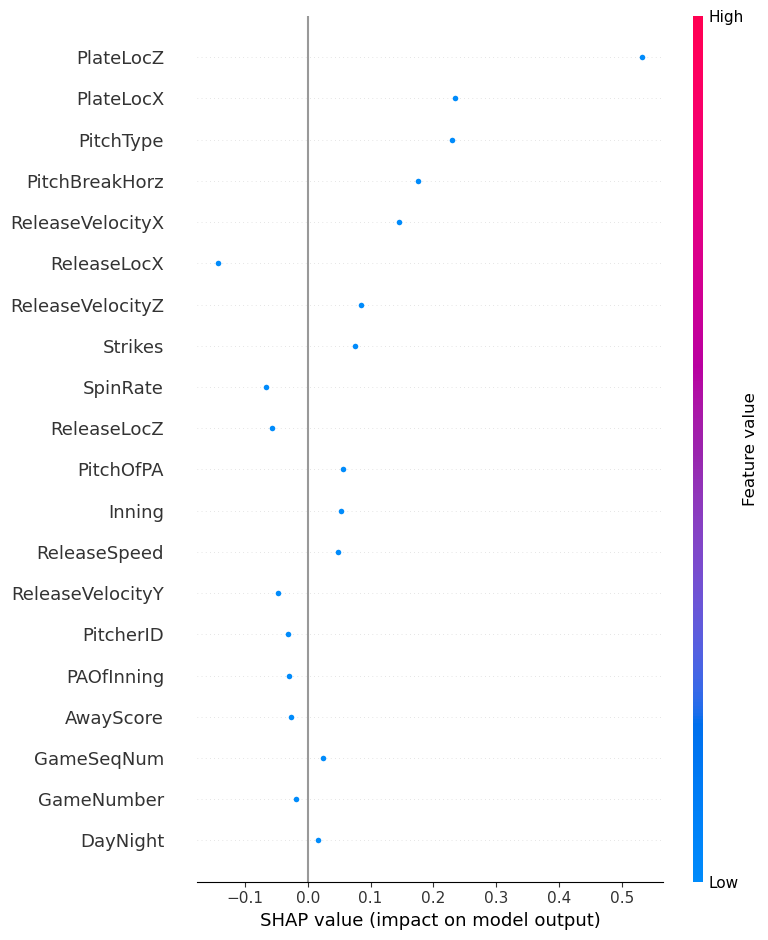

In [139]:
# First we will filter our data frame to only reflect our top pitcher
pitcher_1 = holdout_eng[(holdout_eng['PitcherID'] == 364506) & (holdout_eng['PitchType'] == 2)]

# 3. Calculate SHAP values for the filtered data
shap_values_filtered_1 = explainer.shap_values(pitcher_1)

# Visualize the SHAP values (summary plot)
shap.summary_plot(shap_values_filtered_1, pitcher_1)

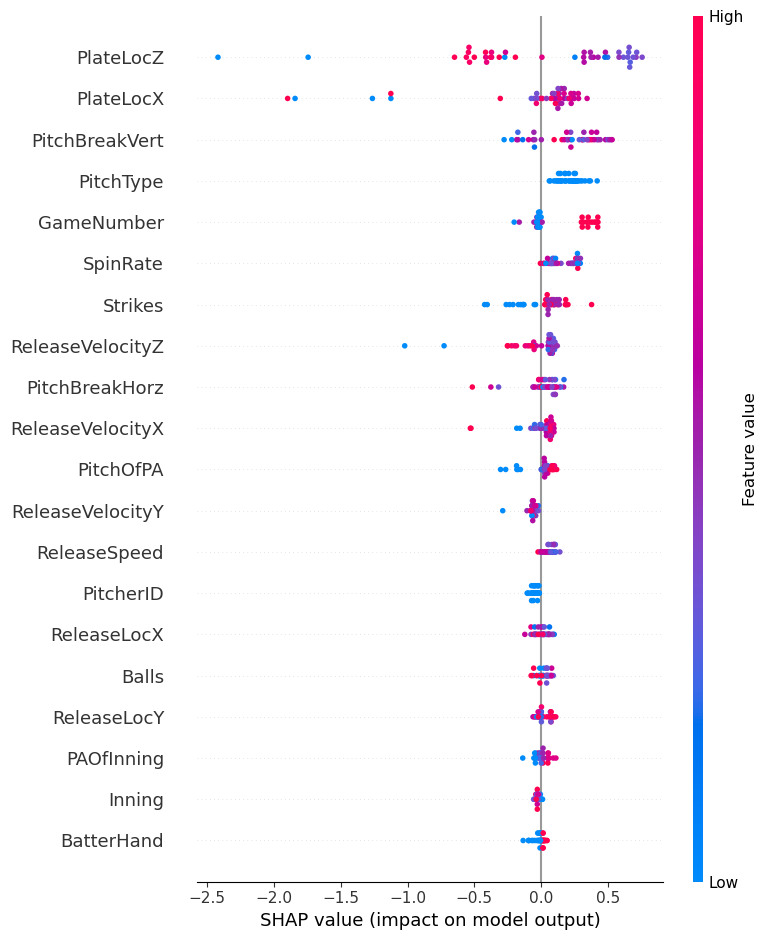

In [145]:
# Now we do the same for our second most successful pitcher

# First we will filter our data frame to only reflect our second top pitcher
pitcher_2 = holdout_eng[(holdout_eng['PitcherID'] == 351636) & (holdout_eng['PitchType'] == 6)]

# 3. Calculate SHAP values for the filtered data
shap_values_filtered_2 = explainer.shap_values(pitcher_2)

# Visualize the SHAP values (summary plot)
shap.summary_plot(shap_values_filtered_2, pitcher_2)

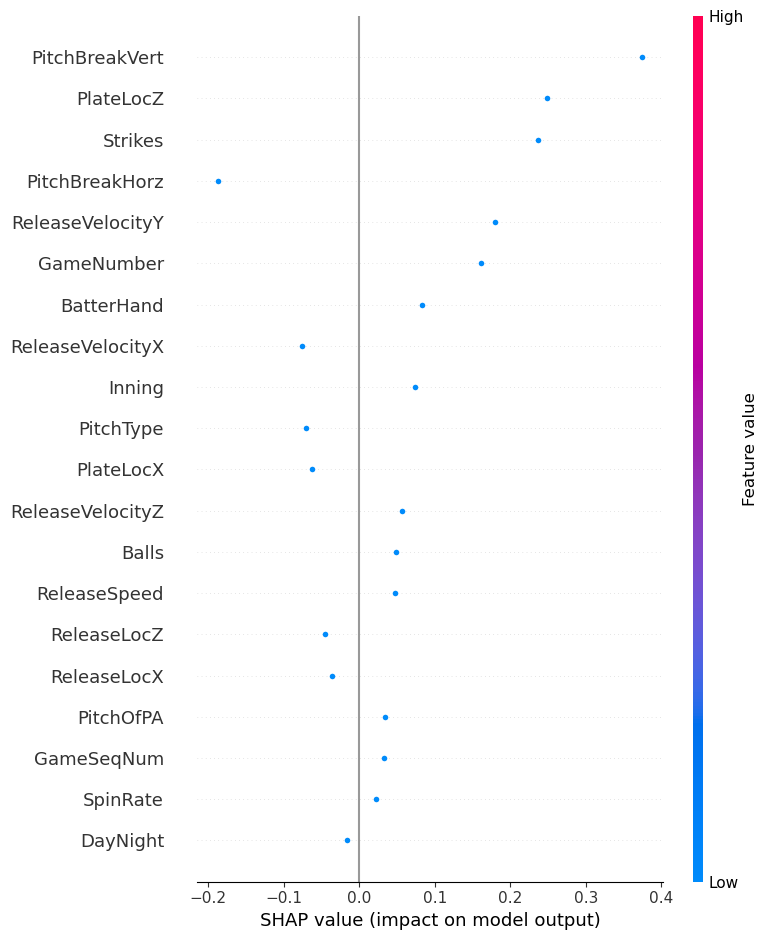

In [148]:
# Now we do the same for our third most successful pitcher

# First we will filter our data frame to only reflect our third top pitcher
pitcher_3 = holdout_eng[(holdout_eng['PitcherID'] == 329342) & (holdout_eng['PitchType'] == 3)]

# 3. Calculate SHAP values for the filtered data
shap_values_filtered_3 = explainer.shap_values(pitcher_3)

# Visualize the SHAP values (summary plot)
shap.summary_plot(shap_values_filtered_3, pitcher_3)

### Exporting train and holdout files to csv.

In [158]:
train.to_csv('train.csv', index=True)

In [160]:
holdout.to_csv('holdout.csv', index=True)